## DeepSensor
### Neural Processes.

* efficiently fuse multi-modal and multi-resolution data,

* handle missing observations,

* capture prediction uncertainty.

Deepsensor plugs the xarray, pandas, and neuralprocesses packages with a user-friendly interface that enables rapid experimentation.

### Data Sources

The following data sources are currently supported:

* GHCND: Global Historical Climatology Network Daily (GHCND) station data

* ERA5: ERA5 reanalysis data

* EarthEnv: EarthEnv elevation and Topographic Position Index (TPI) data at various resolutions (1 km, 5 km, 10 km, 50 km, 100 km)

* GLDAS: Global Land Data Assimilation System (GLDAS) 0.25 degree resolution binary land mask.

In [1]:
import logging
logging.captureWarnings(True)

import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

# Cache the data in root of docs/ folder, so that other notebook don't need to download it again
cache_dir = "./mycache"

import pandas as pd

In [2]:
from deepsensor.data.sources import get_ghcnd_station_data, get_era5_reanalysis_data, \
    get_earthenv_auxiliary_data, get_gldas_land_mask

In [3]:
data_range = ("2015-06-25", "2015-06-30")
extent = "europe"

### Off-the-grid station data.
* Pandas dataframes are used to store off grid station data.
* variable_id is column name.
* each column is treated as separate variables.

In [4]:
station_var_IDs = ["TAVG", "PRCP"]
station_raw_df = get_ghcnd_station_data(station_var_IDs, extent, date_range=data_range, cache=True, cache_dir=cache_dir)
station_raw_df

PRCP  TAVG
time       lat    lon     station                
2015-06-25 35.017 -1.450  AGM00060531   0.0  23.0
           35.100 -1.850  AGE00147716   0.0  23.4
           35.117  36.750 SYM00040030   NaN  25.4
           35.167  2.317  AGM00060514   0.0  25.9
           35.200 -0.617  AGM00060520   0.0  24.9
...                                     ...   ...
2015-06-30 45.933  7.700  ITM00016052   NaN   5.7
           38.367 -0.500  SPM00008359   0.0  27.6
           55.383  36.700 RSM00027611   0.0  17.2
           59.080  17.860 SWE00138750   0.0   NaN
           63.760  12.430 SWE00140158   0.6   NaN

[16928 rows x 2 columns]

In [5]:
station_raw_df.reset_index().drop(columns=["station"]).set_index(['time','lat','lon'])

PRCP  TAVG
time       lat    lon                
2015-06-25 35.017 -1.450    0.0  23.0
           35.100 -1.850    0.0  23.4
           35.117  36.750   NaN  25.4
           35.167  2.317    0.0  25.9
           35.200 -0.617    0.0  24.9
...                         ...   ...
2015-06-30 45.933  7.700    NaN   5.7
           38.367 -0.500    0.0  27.6
           55.383  36.700   0.0  17.2
           59.080  17.860   0.0   NaN
           63.760  12.430   0.6   NaN

[16928 rows x 2 columns]

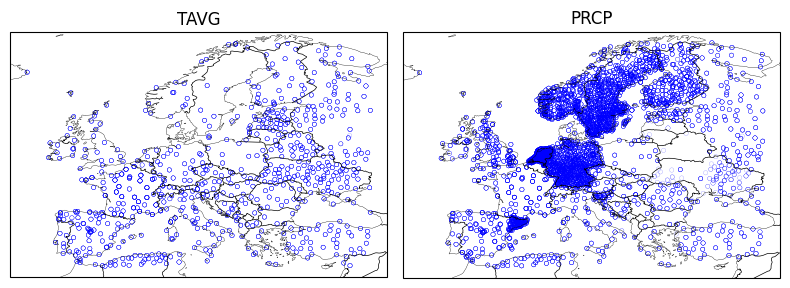

In [6]:
# Plate-carree is a projection 

fig, axes = plt.subplots(1, len(station_var_IDs), subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(4 * len(station_var_IDs), 4))
for ax, var_ID in zip(axes, station_var_IDs):
    df = station_raw_df[var_ID].dropna(how="any").reset_index()
    ax.scatter(df.lon, df.lat, transform=ccrs.PlateCarree(), color="b", marker="o", s=10, linewidth=0.1, facecolors='none')
    ax.coastlines(linewidths=0.25)
    ax.add_feature(cfeature.BORDERS, linewidths=0.5)
    ax.set_title(var_ID)
plt.tight_layout()

### Spatiotemporal data.
* Reanalysis/ Satellite Data.
* xarray dataarray/datasets are used to represent data.
* variable_ID is the variable name in dataset,dataarray.
* dimensions must be (time, y, x)

In [7]:
era5_var_IDs = ["2m_temperature", "10m_u_component_of_wind", "10m_v_component_of_wind"] 
era5_raw_ds = get_era5_reanalysis_data(era5_var_IDs, extent, date_range=data_range, cache=True, cache_dir=cache_dir)
era5_raw_ds

<xarray.Dataset> Size: 2MB
Dimensions:                  (time: 6, lat: 141, lon: 221)
Coordinates:
  * lat                      (lat) float32 564B 70.0 69.75 69.5 ... 35.25 35.0
  * lon                      (lon) float32 884B -15.0 -14.75 ... 39.75 40.0
  * time                     (time) datetime64[ns] 48B 2015-06-25 ... 2015-06-30
Data variables:
    2m_temperature           (time, lat, lon) float32 748kB 274.7 ... 297.0
    10m_u_component_of_wind  (time, lat, lon) float32 748kB 6.309 ... 4.798
    10m_v_component_of_wind  (time, lat, lon) float32 748kB 3.221 ... -4.844
Attributes:
    valid_time_start:  1940-01-01
    last_updated:      2024-10-17 20:04:10.783634
    valid_time_stop:   2024-07-31

In [66]:
era5_df = era5_raw_ds.to_dataframe()
era5_df

2m_temperature  10m_u_component_of_wind  \
time       lat  lon                                               
2015-06-25 70.0 -15.00      274.708282                 6.308839   
                -14.75      274.805206                 6.304796   
                -14.50      274.892029                 6.305350   
                -14.25      274.951813                 6.319665   
                -14.00      275.013947                 6.313209   
...                                ...                      ...   
2015-06-30 35.0  39.00      293.874298                 4.402323   
                 39.25      294.855621                 4.862969   
                 39.50      295.733765                 5.150125   
                 39.75      296.461792                 5.154612   
                 40.00      296.970276                 4.797910   

                        10m_v_component_of_wind  
time       lat  lon                              
2015-06-25 70.0 -15.00                 3.220673  
                -14.75                 3.104521  
                -14.50                 2.990033  
                -14.25                 2.879375  
                -14.00                 2.734900  
...                                         ...  
2015-06-30 35.0  39.00                -5.489881  
                 39.25                -6.006480  
                 39.50                -5.895375  
                 39.75                -5.375531  
                 40.00                -4.843523  

[186966 rows x 3 columns]

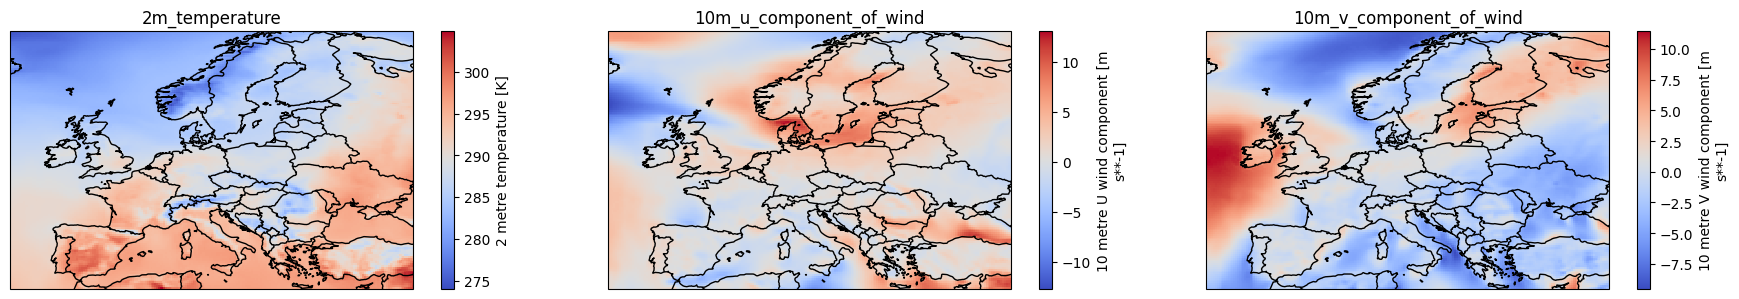

In [8]:
fig, axes = plt.subplots(1, len(era5_var_IDs), subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(6 * len(era5_var_IDs), 3))
for ax, var_ID in zip(axes, era5_var_IDs):
    era5_raw_ds[var_ID].isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree(), center=False, cmap="coolwarm")
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    ax.set_title(var_ID)
plt.tight_layout()

### Static Gridded Data.
* Static variables may provide information that aid predicting our target variables.
* Topography - affects surface temperature. Soil type - affect soil moisture.
* Auxiliary variables with no time and dimension.
* 1KM resolution elevation, Topographic Position Index(TPI) data from EarthEnv, land mask from GLDAS.

In [9]:
auxiliary_var_IDs = ["elevation", "tpi"]
da = get_earthenv_auxiliary_data(auxiliary_var_IDs, extent, "1KM", cache=True, cache_dir=cache_dir)
da

<xarray.Dataset> Size: 222MB
Dimensions:    (lon: 6600, lat: 4200)
Coordinates:
  * lon        (lon) float64 53kB -15.0 -14.99 -14.98 ... 39.98 39.99 40.0
  * lat        (lat) float64 34kB 70.0 69.99 69.98 69.97 ... 35.02 35.01 35.0
Data variables:
    elevation  (lat, lon) float32 111MB 0.0 0.0 0.0 0.0 ... 261.6 261.5 260.6
    tpi        (lat, lon) float32 111MB 0.0 0.0 0.0 ... 0.03906 0.07812 0.1641

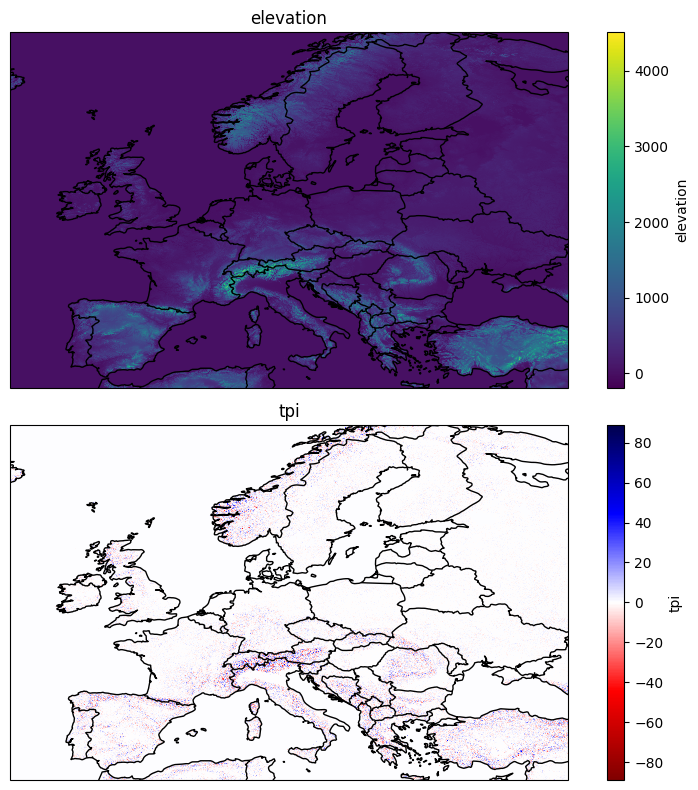

In [10]:
fig, axes = plt.subplots(len(da.data_vars), 1, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(8, 4 * len(da.data_vars)))
for ax, var_ID in zip(axes, da.data_vars):
    if var_ID == "tpi":
        maxabs = max(abs(da[var_ID].min()), abs(da[var_ID].max()))
        da[var_ID].plot(ax=ax, transform=ccrs.PlateCarree(), cmap="seismic_r", vmin=-maxabs, vmax=maxabs)
    else:
        da[var_ID].plot(ax=ax, transform=ccrs.PlateCarree(), center=False, cmap="viridis")
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    ax.set_title(var_ID)
plt.tight_layout()


In [11]:
land_da = get_gldas_land_mask(extent, cache=True, cache_dir=cache_dir)
land_da

<xarray.DataArray 'GLDAS_mask' (lat: 140, lon: 220)> Size: 123kB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]], dtype=float32)
Coordinates:
  * lon      (lon) float32 880B -14.88 -14.62 -14.38 ... 39.38 39.62 39.88
  * lat      (lat) float32 560B 69.88 69.62 69.38 69.12 ... 35.62 35.38 35.12

In [12]:
land_da.to_dataframe()

GLDAS_mask
lat    lon                
69.875 -14.875         0.0
       -14.625         0.0
       -14.375         0.0
       -14.125         0.0
       -13.875         0.0
...                    ...
35.125  38.875         1.0
        39.125         1.0
        39.375         1.0
        39.625         1.0
        39.875         1.0

[30800 rows x 1 columns]

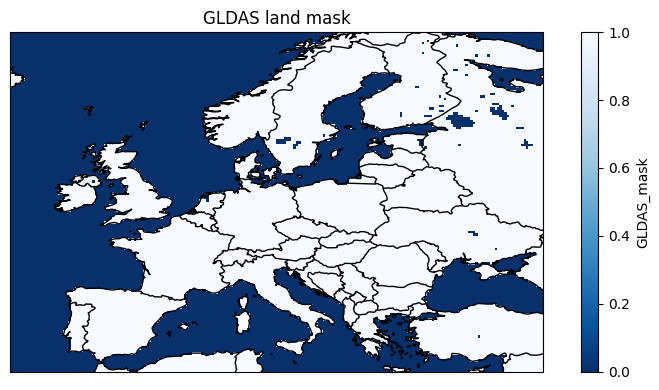

In [13]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(8, 4))
land_da.plot(ax=ax, transform=ccrs.PlateCarree(), center=False, cmap="Blues_r")
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.set_title("GLDAS land mask")
plt.tight_layout()